In [1]:
cd /g/data/jk72/deg581/apom/ana/notebooks

/g/data/jk72/deg581/apom/ana/notebooks


In [2]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import matplotlib.ticker as mticker

## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
# import repackage
# repackage.add('../../')
# repackage.add('../')

In [3]:

def inpolygon(xq, yq, xv, yv):
    from matplotlib import path
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)

# map u,v to rho points
def ROMSmetricsAndGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    print('making pm/pn metrics')
    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)
    print('making dx/dy')
    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

#     ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
#     ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
#     ds['dz_u'] = grid.interp(ds.dz, 'X')
#     ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
#     ds['dz_v'] = grid.interp(ds.dz, 'Y')
#     ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        # ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds,grid



def add_zeros_to_4(date):
    if date<10:
        to_add = '000'
    elif date>9 & date<100:
        to_add = '00'
    elif date>99 & date < 1000:
        to_add = '0'
    else: 
        to_add = ''
    return to_add

def generateFileList(FilePath,prefix,datelist):
    filelist=[FilePath+prefix+add_zeros_to_4(datelist[0])+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=FilePath+prefix+add_zeros_to_4(dates)+str(dates)+'.nc'
        filelist.append(filenameToAppend)
    return filelist

### load data sets

In [4]:
grd = xr.open_dataset('/g/data/jk72/deg581/apom/frc/amery_v2km_v13_grd.nc')


In [5]:


FilePath='/g/data/gv90/bkg581/prd_amery/amery_CTRL/' # Truth file settings
prefix='roms_avg_'
timeRange = [43, 44]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds.nbytes/1e9,'G')

ds = ds.drop_vars(['sustr','svstr','ssflux','shflux','AKt','AKv','Hsbl','w','ubar','vbar'])
ds['my'] = ds.m*(60*60*24*365)
print(ds.nbytes/1e9,'G')
ds

ds = ds.assign_coords({"x_rho": grd.x_rho})
ds = ds.assign_coords({"y_rho": grd.y_rho})
ds = ds.assign_coords({"lon_rho": grd.lon_rho})
ds = ds.assign_coords({"lat_rho": grd.lat_rho})

# ds['hc'] = grd.hc
# ds['s_w']=grd.s_w
# ds['s_rho']=grd.s_rho
# ds['Cs_w']=grd.Cs_w
# ds['Cs_r']=grd.Cs_r


# ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice

ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)

ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)

# make masks

poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])
# plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# plt.show()



mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'amery'
ds.mask_zice_roi.attrs['long_name']=roi_label1

# set any grid data here.

weights_area = (1/ds.pm)*(1/ds.pn)
weights_area.name = "weights"

print('making vertical coordinates')
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = (ds.zice) + ((ds.zice) + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * ((ds.zice) + ds.h) + (ds.zice)
    
ds.coords['z_w0'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho0'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')

# ds['dz'] = (('ocean_time','s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w,axis=1))

ds, grid = ROMSmetricsAndGrid(ds)

print('mapping u/v to u/v rho')
ds['u_rho'] = grid.interp(ds.u,'X')
ds['v_rho'] = grid.interp(ds.v,'Y')


print('correctly mask melt')
ds['m'] = ds.m*ds.mask_ziceNaN
ds['my'] = ds.m*(60*60*24*365)


ds_CTRL = ds

ds.close()

['/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0043.nc']
51.91852368 G
32.01238728 G
making vertical coordinates
making pm/pn metrics
making dx/dy
mapping u/v to u/v rho
correctly mask melt


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return

In [6]:


FilePath='/g/data/gv90/bkg581/prd_amery/amery_MKPA/' # Truth file settings
prefix='roms_avg_'
timeRange = [43, 44]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds.nbytes/1e9,'G')

ds = ds.drop_vars(['sustr','svstr','ssflux','shflux','AKt','AKv','Hsbl','w','ubar','vbar'])
ds['my'] = ds.m*(60*60*24*365)
print(ds.nbytes/1e9,'G')
ds

ds = ds.assign_coords({"x_rho": grd.x_rho})
ds = ds.assign_coords({"y_rho": grd.y_rho})
ds = ds.assign_coords({"lon_rho": grd.lon_rho})
ds = ds.assign_coords({"lat_rho": grd.lat_rho})

# ds['hc'] = grd.hc
# ds['s_w']=grd.s_w
# ds['s_rho']=grd.s_rho
# ds['Cs_w']=grd.Cs_w
# ds['Cs_r']=grd.Cs_r


# ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice

ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)

ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)

# make masks

poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])
# plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# plt.show()



mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'amery'
ds.mask_zice_roi.attrs['long_name']=roi_label1

# set any grid data here.

weights_area = (1/ds.pm)*(1/ds.pn)
weights_area.name = "weights"

print('making vertical coordinates')
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = (ds.zice) + ((ds.zice) + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * ((ds.zice) + ds.h) + (ds.zice)
    
ds.coords['z_w0'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho0'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')

# ds['dz'] = (('ocean_time','s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w,axis=1))

ds, grid = ROMSmetricsAndGrid(ds)

print('correctly mask melt')
ds['m'] = ds.m*ds.mask_ziceNaN
ds['my'] = ds.m*(60*60*24*365)


print('mapping u/v to u/v rho')
ds['u_rho'] = grid.interp(ds.u,'X')
ds['v_rho'] = grid.interp(ds.v,'Y')

ds_MKPA = ds

ds.close()

['/g/data/gv90/bkg581/prd_amery/amery_MKPA/roms_avg_0043.nc']
51.91852368 G
32.01238728 G
making vertical coordinates
making pm/pn metrics
making dx/dy
correctly mask melt
mapping u/v to u/v rho


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return

In [7]:


FilePath='/g/data/gv90/bkg581/prd_amery/amery_MKPB/' # Truth file settings
prefix='roms_avg_'
timeRange = [43, 44]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds.nbytes/1e9,'G')

ds = ds.drop_vars(['sustr','svstr','ssflux','shflux','AKt','AKv','Hsbl','w','ubar','vbar'])
ds['my'] = ds.m*(60*60*24*365)
print(ds.nbytes/1e9,'G')
ds

ds = ds.assign_coords({"x_rho": grd.x_rho})
ds = ds.assign_coords({"y_rho": grd.y_rho})
ds = ds.assign_coords({"lon_rho": grd.lon_rho})
ds = ds.assign_coords({"lat_rho": grd.lat_rho})

# ds['hc'] = grd.hc
# ds['s_w']=grd.s_w
# ds['s_rho']=grd.s_rho
# ds['Cs_w']=grd.Cs_w
# ds['Cs_r']=grd.Cs_r


# ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice

ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)

ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)

# make masks

poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])
# plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# plt.show()



mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'amery'
ds.mask_zice_roi.attrs['long_name']=roi_label1

# set any grid data here.

weights_area = (1/ds.pm)*(1/ds.pn)
weights_area.name = "weights"

print('making vertical coordinates')
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = (ds.zice) + ((ds.zice) + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * ((ds.zice) + ds.h) + (ds.zice)
    
ds.coords['z_w0'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho0'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')

# ds['dz'] = (('ocean_time','s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w,axis=1))

ds, grid = ROMSmetricsAndGrid(ds)

print('mapping u/v to u/v rho')
ds['u_rho'] = grid.interp(ds.u,'X')
ds['v_rho'] = grid.interp(ds.v,'Y')

print('correctly mask melt')
ds['m'] = ds.m*ds.mask_ziceNaN
ds['my'] = ds.m*(60*60*24*365)


ds_MKPB = ds

ds.close()

['/g/data/gv90/bkg581/prd_amery/amery_MKPB/roms_avg_0043.nc']
51.91852368 G
32.01238728 G
making vertical coordinates
making pm/pn metrics
making dx/dy
mapping u/v to u/v rho


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return

correctly mask melt


In [8]:

grd['hc']=ds.hc
grd['s_w']=ds.s_w
grd['s_rho']=ds.s_rho
grd['Cs_w']=ds.Cs_w
grd['Cs_r']=ds.Cs_r


In [9]:
# now load lima

import rioxarray

lima_full = rioxarray.open_rasterio('../data/raw/lima/00000-20080319-092059124.tif')

lima = lima_full.where((lima_full.x>1.68e6)&(lima_full.x<2.5e6)&(lima_full.y>.4e6)&(lima_full.y<1e6),drop=True)


### finished preliminary loading data

In [10]:


FilePath='/g/data/gv90/bkg581/prd_amery/amery_CTRL/' # Truth file settings
prefix='roms_avg_'
timeRange = [49, 54]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds.nbytes/1e9,'G')

ds = ds.drop_vars(['sustr','svstr','ssflux','shflux','AKt','AKv','Hsbl','w','ubar','vbar'])
ds['my'] = ds.m*(60*60*24*365)
print(ds.nbytes/1e9,'G')
ds

ds = ds.assign_coords({"x_rho": grd.x_rho})
ds = ds.assign_coords({"y_rho": grd.y_rho})
ds = ds.assign_coords({"lon_rho": grd.lon_rho})
ds = ds.assign_coords({"lat_rho": grd.lat_rho})

# ds['hc'] = grd.hc
# ds['s_w']=grd.s_w
# ds['s_rho']=grd.s_rho
# ds['Cs_w']=grd.Cs_w
# ds['Cs_r']=grd.Cs_r


# ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice

ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)

ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)

# make masks

poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])
# plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# plt.show()



mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'amery'
ds.mask_zice_roi.attrs['long_name']=roi_label1

# set any grid data here.

weights_area = (1/ds.pm)*(1/ds.pn)
weights_area.name = "weights"

print('making vertical coordinates')
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = (ds.zice) + ((ds.zice) + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * ((ds.zice) + ds.h) + (ds.zice)
    
ds.coords['z_w0'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho0'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')

# ds['dz'] = (('ocean_time','s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w,axis=1))

ds, grid = ROMSmetricsAndGrid(ds)

print('mapping u/v to u/v rho')
ds['u_rho'] = grid.interp(ds.u,'X')
ds['v_rho'] = grid.interp(ds.v,'Y')

ds_CTRL = ds

ds.close()

['/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0049.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0050.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0051.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0052.nc', '/g/data/gv90/bkg581/prd_amery/amery_CTRL/roms_avg_0053.nc']
259.204128416 G
159.673446416 G
making vertical coordinates
making pm/pn metrics
making dx/dy
mapping u/v to u/v rho


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return

In [11]:


FilePath='/g/data/gv90/bkg581/prd_amery/amery_MKPA/' # Truth file settings
prefix='roms_avg_'
timeRange = [49, 54]
datelist = np.array(range(timeRange[0],timeRange[1],1))


fl=generateFileList(FilePath,prefix,datelist)
print(fl)

# ds=loadOverlappedNetcdfFileList(filelist=fl,overlapDays=7)

ds = xr.open_mfdataset(fl,chunks = {'ocean_time':1}, data_vars='minimal', compat='override',coords='minimal',parallel='False',join='right')

print(ds.nbytes/1e9,'G')

ds = ds.drop_vars(['sustr','svstr','ssflux','shflux','AKt','AKv','Hsbl','w','ubar','vbar'])
ds['my'] = ds.m*(60*60*24*365)
print(ds.nbytes/1e9,'G')
ds

ds = ds.assign_coords({"x_rho": grd.x_rho})
ds = ds.assign_coords({"y_rho": grd.y_rho})
ds = ds.assign_coords({"lon_rho": grd.lon_rho})
ds = ds.assign_coords({"lat_rho": grd.lat_rho})

# ds['hc'] = grd.hc
# ds['s_w']=grd.s_w
# ds['s_rho']=grd.s_rho
# ds['Cs_w']=grd.Cs_w
# ds['Cs_r']=grd.Cs_r


# ds_raw = ds_raw.assign_coords(lon_rho=grd.lon_rho)
# ds_raw = ds_raw.assign_coords(lat_rho=grd.lat_rho)

ds['mask_zice'] = (ds.mask_rho.where(ds.zice<0)==1) # make a logic mask for ice

ds['mask_openocean'] = ds.mask_rho*(ds.mask_zice==0)

ds['mask_openoceanNaN'] = ds.mask_openocean.where(ds.mask_openocean)

ds['mask_rhoNaN'] = ds.mask_rho.where(ds.mask_rho)

ds['mask_ziceNaN'] = ds.mask_zice.where(ds.mask_zice)

# make masks

poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])
# plt.plot(poly_shelf[:,0],poly_shelf[:,1])
# plt.show()



mask_roi = inpolygon(ds.x_rho.values, ds.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])


ds['mask_zice_roi'] = ds.mask_zice*mask_roi
# ds.mask_zice_roi.plot()
roi_label1 = 'amery'
ds.mask_zice_roi.attrs['long_name']=roi_label1

# set any grid data here.

weights_area = (1/ds.pm)*(1/ds.pn)
weights_area.name = "weights"

print('making vertical coordinates')
Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = (ds.zice) + ((ds.zice) + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * ((ds.zice) + ds.h) + (ds.zice)
    
ds.coords['z_w0'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho0'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')

# ds['dz'] = (('ocean_time','s_rho', 'eta_rho', 'xi_rho'),np.diff(ds.z_w,axis=1))

ds, grid = ROMSmetricsAndGrid(ds)

print('mapping u/v to u/v rho')
ds['u_rho'] = grid.interp(ds.u,'X')
ds['v_rho'] = grid.interp(ds.v,'Y')

ds_MKPA = ds

ds.close()

['/g/data/gv90/bkg581/prd_amery/amery_MKPA/roms_avg_0049.nc', '/g/data/gv90/bkg581/prd_amery/amery_MKPA/roms_avg_0050.nc', '/g/data/gv90/bkg581/prd_amery/amery_MKPA/roms_avg_0051.nc', '/g/data/gv90/bkg581/prd_amery/amery_MKPA/roms_avg_0052.nc', '/g/data/gv90/bkg581/prd_amery/amery_MKPA/roms_avg_0053.nc']
259.204128416 G
159.673446416 G
making vertical coordinates
making pm/pn metrics
making dx/dy
mapping u/v to u/v rho


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return

In [12]:
print(' make dayofyear means ')
print(' have to first fix the time coordinate to ignore the leap year. sigh.')

No_of_years=5
dayofyear = np.concatenate([np.array((356,361)),np.tile(np.arange(1,365,5),No_of_years-1),np.arange(1,365-10,5)])
dayofyear_da = xr.DataArray(dayofyear,[('day',dayofyear)])

ds_CTRL['day']=dayofyear_da
ds_CTRL['salt_doy']=ds_CTRL.salt.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_CTRL['my_doy']=ds_CTRL.my.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_CTRL['temp_doy']=ds_CTRL.temp.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_CTRL['u_rho_doy']=ds_CTRL.u_rho.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_CTRL['v_rho_doy']=ds_CTRL.v_rho.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()

ds_MKPA['day']=dayofyear_da
ds_MKPA['salt_doy']=ds_MKPA.salt.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_MKPA['my_doy']=ds_MKPA.my.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_MKPA['temp_doy']=ds_MKPA.temp.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_MKPA['u_rho_doy']=ds_MKPA.u_rho.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()
ds_MKPA['v_rho_doy']=ds_MKPA.v_rho.assign_coords(dayofyear=("ocean_time",dayofyear_da.data)).groupby('dayofyear').mean()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False


 make dayofyear means 
 have to first fix the time coordinate to ignore the leap year. sigh.


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, re

In [13]:
%%time


# dump the big fields
ds_CTRL = ds_CTRL.drop_vars(['m','Tstar','Ustar','u','v','temp','salt','rho','zeta','Tb','my','u_rho','v_rho'])
print(ds_CTRL.nbytes/1e9,'G')
ds_CTRL.load()

ds_MKPA = ds_MKPA.drop_vars(['m','Tstar','Ustar','u','v','temp','salt','rho','zeta','Tb','my','u_rho','v_rho'])
print(ds_MKPA.nbytes/1e9,'G')
ds_MKPA.load()


25.386573352 G
25.386573352 G
CPU times: user 1h 10min 56s, sys: 52min 39s, total: 2h 3min 35s
Wall time: 17min 19s


<xarray.Dataset> Size: 25GB
Dimensions:            (tracer: 2, boundary: 4, s_rho: 31, s_w: 32,
                        eta_rho: 750, xi_rho: 900, xi_u: 899, eta_v: 749,
                        ocean_time: 365, day: 365, dayofyear: 73)
Coordinates: (12/17)
  * s_rho              (s_rho) float64 248B -0.9839 -0.9516 ... -0.01613
  * s_w                (s_w) float64 256B -1.0 -0.9677 -0.9355 ... -0.03226 0.0
    x_rho              (eta_rho, xi_rho) float64 5MB 1.501e+06 ... 3.299e+06
    y_rho              (eta_rho, xi_rho) float64 5MB 1e+03 1e+03 ... 1.499e+06
    x_u                (eta_rho, xi_u) float64 5MB 1.502e+06 ... 3.298e+06
    y_u                (eta_rho, xi_u) float64 5MB 1e+03 1e+03 ... 1.499e+06
    ...                 ...
    lon_rho            (eta_rho, xi_rho) float64 5MB 89.96 89.96 ... 65.55 65.56
    lat_rho            (eta_rho, xi_rho) float64 5MB -76.25 -76.23 ... -57.51
    z_w0               (s_w, eta_rho, xi_rho) float64 173MB 0.0 0.0 ... 0.0 0.0
    z_rho0             (s_rho, eta_rho, xi_rho) float64 167MB 0.0 0.0 ... -3.873
  * day                (day) int64 3kB 356 361 1 6 11 16 ... 331 336 341 346 351
  * dayofyear          (dayofyear) int64 584B 1 6 11 16 21 ... 346 351 356 361
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/96)
    ntimes             int32 4B 131400
    ndtfast            int32 4B 40
    dt                 float64 8B 240.0
    dtfast             float64 8B 6.0
    dstart             datetime64[ns] 8B 2007-01-01
    nHIS               int32 4B 1800
    ...                 ...
    dA                 (eta_rho, xi_rho) float64 5MB 4.073e+06 ... 3.574e+06
    salt_doy           (dayofyear, s_rho, eta_rho, xi_rho) float32 6GB nan .....
    my_doy             (dayofyear, eta_rho, xi_rho) float64 394MB nan ... 0.0
    temp_doy           (dayofyear, s_rho, eta_rho, xi_rho) float32 6GB nan .....
    u_rho_doy          (dayofyear, s_rho, eta_rho, xi_rho) float32 6GB nan .....
    v_rho_doy          (dayofyear, s_rho, eta_rho, xi_rho) float32 6GB nan .....
Attributes: (12/35)
    file:              /g/data/gv90/bkg581/prd_amery/amery_MKPA/roms_avg_0049.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS nonlinear model averages file
    title:             Amery Ice Shelf-ocean Application
    var_info:          ROMS/External/varinfo.yaml
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 4.1, Wednesday - October 2, 2024 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       AMERY, ADD_FSOBC, ANA_BSFLUX, ANA_BTFLUX, ANA_INITIAL,...

/jobfs/135837165.gadi-pbs/ipykernel_1753296/81831706.py:96: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = cs.collections[0].get_paths()[0]


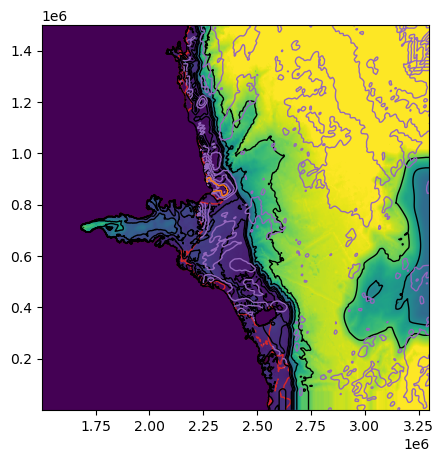

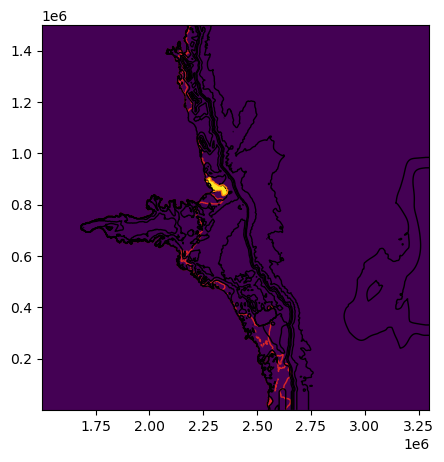

In [14]:

grd['hc']=ds.hc
grd['s_w']=ds.s_w
grd['s_rho']=ds.s_rho
grd['Cs_w']=ds.Cs_w
grd['Cs_r']=ds.Cs_r



# make grid masks


grd['mask_zice'] = (grd.mask_rho.where(grd.zice<0)==1) # make a logic mask for ice
grd['mask_openocean'] = grd.mask_rho*(grd.mask_zice==0)
grd['mask_openoceanNaN'] = grd.mask_openocean.where(grd.mask_openocean)
grd['mask_rhoNaN'] = grd.mask_rho.where(grd.mask_rho)
grd['mask_ziceNaN'] = grd.mask_zice.where(grd.mask_zice)

# amery mask

poly_shelf = np.array([
    [1.55e6,600000],
    [2.25e6,600000],
    [2.25e6,800000],
    [2.20e6,830000],
    [1.55e6,890000]])

mask_roi = inpolygon(grd.x_rho.values, grd.y_rho.values,poly_shelf[:,0], poly_shelf[:,1])
grd['mask_zice_roi'] = grd.mask_zice*mask_roi
roi_label1 = 'amery'
grd.mask_zice_roi.attrs['long_name']=roi_label1

# polyna-center masks

ds_his = xr.open_dataset('/g/data/jk72/deg581/apom/frc/amery_v2km_tamura+era_swflux.nc')
swflux = ds_his["swflux"] 
ds_his.close()
del ds_his


plotting=False
if plotting==True:
    plt.figure(figsize=(5,5))
    plt.pcolormesh(ds.h*ds.mask_rho)
    plt.contour(ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
    co2 = plt.contour(ds.h*ds.mask_rho,levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
    plt.contour(swflux.mean(dim='swf_time')*ds.mask_openoceanNaN,levels=5,colors='C4',linestyles='-',linewidths=1)
    plt.plot(394,438,'x')
    plt.plot(364,393,'x')
    plt.plot(391,461,'x')
    plt.colorbar()
    plt.axis((300,500,250,500))

mask_burton_center = np.zeros_like(grd.lon_rho)
mask_burton_center[461:461+4,391:391+4]=1

mask_capedarnley_center = np.zeros_like(grd.lon_rho)
mask_capedarnley_center[437:437+4,393:393+4]=1

mask_mackenzie_center = np.zeros_like(grd.lon_rho)
mask_mackenzie_center[392:392+4,363:363+4]=1

mask_fasticetongue = np.zeros_like(grd.lon_rho)
mask_fasticetongue[400:425,367:425]=1
mask_fasticetongue = mask_fasticetongue*grd.mask_zice

if plotting==True:
    plt.figure(figsize=(5,5))
    plt.pcolormesh(mask_fasticetongue*ds.zice,vmin=-10,vmax=0)
    plt.colorbar()
    plt.contour(ds.zice*ds.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
    plt.axis((300,500,250,500))


# make polynya-area masks


ds_his = xr.open_dataset('/g/data/jk72/deg581/apom/frc/amery_v2km_tamura+era_swflux.nc')
swflux = ds_his["swflux"] 
ds_his.close()
del ds_his


mask_capedarnley_tempo = np.zeros_like(grd.lon_rho)
mask_capedarnley_tempo[410:460,380:450]=1

plt.figure(figsize=(5,5))
plt.pcolormesh(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho)
plt.contour(grd.x_rho,grd.y_rho,grd.zice*grd.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
co2 = plt.contour(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho,levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
plt.contour(grd.x_rho,grd.y_rho,swflux.mean(dim='swf_time')*grd.mask_openoceanNaN,levels=5,colors='C4',linestyles='-',linewidths=1)

cs = plt.contour(grd.x_rho,grd.y_rho,swflux.mean(dim='swf_time')*grd.mask_openoceanNaN*mask_capedarnley_tempo,levels=[2.8e-7],colors='C1',linestyles='-',linewidths=1) # units of m/s

# paths = cs.get_paths()[0].to_polygons()
# plt.plot(paths[1][:,0],paths[1][:,1])
p = cs.collections[0].get_paths()[0]
v = p.vertices
x = v[:,0]
y = v[:,1]
mask_capedarnley_tempo2 = inpolygon(grd.x_rho.values, grd.y_rho.values, x, y)


plt.figure(figsize=(5,5))
plt.contour(grd.x_rho,grd.y_rho,grd.zice*grd.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)
co2 = plt.contour(grd.x_rho,grd.y_rho,grd.h*grd.mask_rho,levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
cs = plt.contour(grd.x_rho,grd.y_rho,swflux.mean(dim='swf_time')*grd.mask_openoceanNaN*mask_capedarnley_tempo,levels=[2.8e-7],colors='C1',linestyles='-',linewidths=1) # units of m/s

plt.pcolormesh(grd.x_rho,grd.y_rho,mask_capedarnley_tempo2*grd.mask_openocean)

mask_capedarnley = mask_capedarnley_tempo2*grd.mask_openocean
grd['mask_capedarnley'] = mask_capedarnley


# make CD shelf area mask
mask_CDshelf = (grd.h<1000) & (grd.y_rho<1.1e6) & (grd.y_rho>.85e6) & (grd.mask_rho==1) | ((grd.h>1000) & (grd.x_rho<2.3e6) & (grd.y_rho<1.1e6) & (grd.y_rho>.85e6) & (grd.mask_rho==1))
grd['mask_CDshelf'] = mask_CDshelf


# define weighting parameters

weights = (1/grd.pm)*(1/grd.pn)
weights.name = "weights"



In [15]:
# define time periods
winter_period=slice(51,64)
summer_period=slice(14,27)

print(ds_CTRL.dayofyear.isel(dayofyear=winter_period)[0].values,' to ',ds_CTRL.dayofyear.isel(dayofyear=winter_period)[-1].values)
print(ds_CTRL.dayofyear.isel(dayofyear=summer_period)[0].values,' to ',ds_CTRL.dayofyear.isel(dayofyear=summer_period)[-1].values)

winter_period_doy=slice(49,62)
summer_period_doy=slice(12,25)

print(ds_CTRL.dayofyear.isel(dayofyear=winter_period_doy)[0].values,' to ',ds_CTRL.dayofyear.isel(dayofyear=winter_period_doy)[-1].values)
print(ds_CTRL.dayofyear.isel(dayofyear=summer_period_doy)[0].values,' to ',ds_CTRL.dayofyear.isel(dayofyear=summer_period_doy)[-1].values)

print('PROBABLY  SHOULD REDEFINE WINTER PERIOD WITH THE NEW DAYOFYEAR DATA')


256  to  316
71  to  131
246  to  306
61  to  121
PROBABLY  SHOULD REDEFINE WINTER PERIOD WITH THE NEW DAYOFYEAR DATA


In [16]:
# import seawater as sw
# [sss,ttt]=np.meshgrid(np.arange(34,35,.01),np.arange(-2.4,2,.01))
# ppp = sw.pden(sss,sw.temp(sss,ttt,np.zeros(sss.shape)),np.zeros(sss.shape),0)-1000


# s_pnts = [[0, 40],[0, 40]]
# p_pnts = [[0, 0], [1800, 1800]]
# fp = sw.fp(s_pnts, p_pnts)
# fp0  = fp[0]
# fpDepth = fp[1]



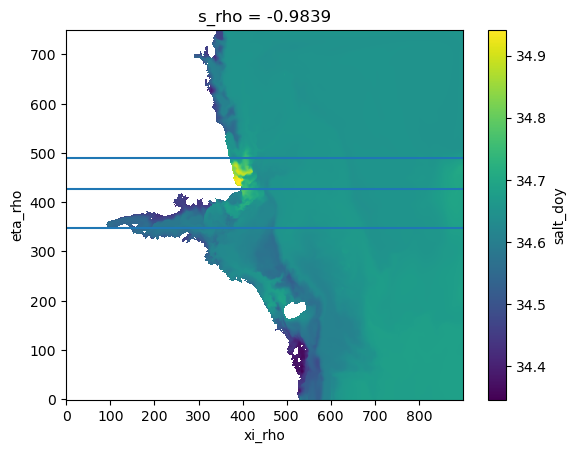

In [40]:
ds_CTRL.salt_doy.isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot()
plt.axhline(348)
plt.axhline(427)
plt.axhline(490)

Text(0.5, 1.0, '$\\Delta$ temp ($^\\circ$C; No-Mackenzie - CTRL)')

<Figure size 640x480 with 0 Axes>

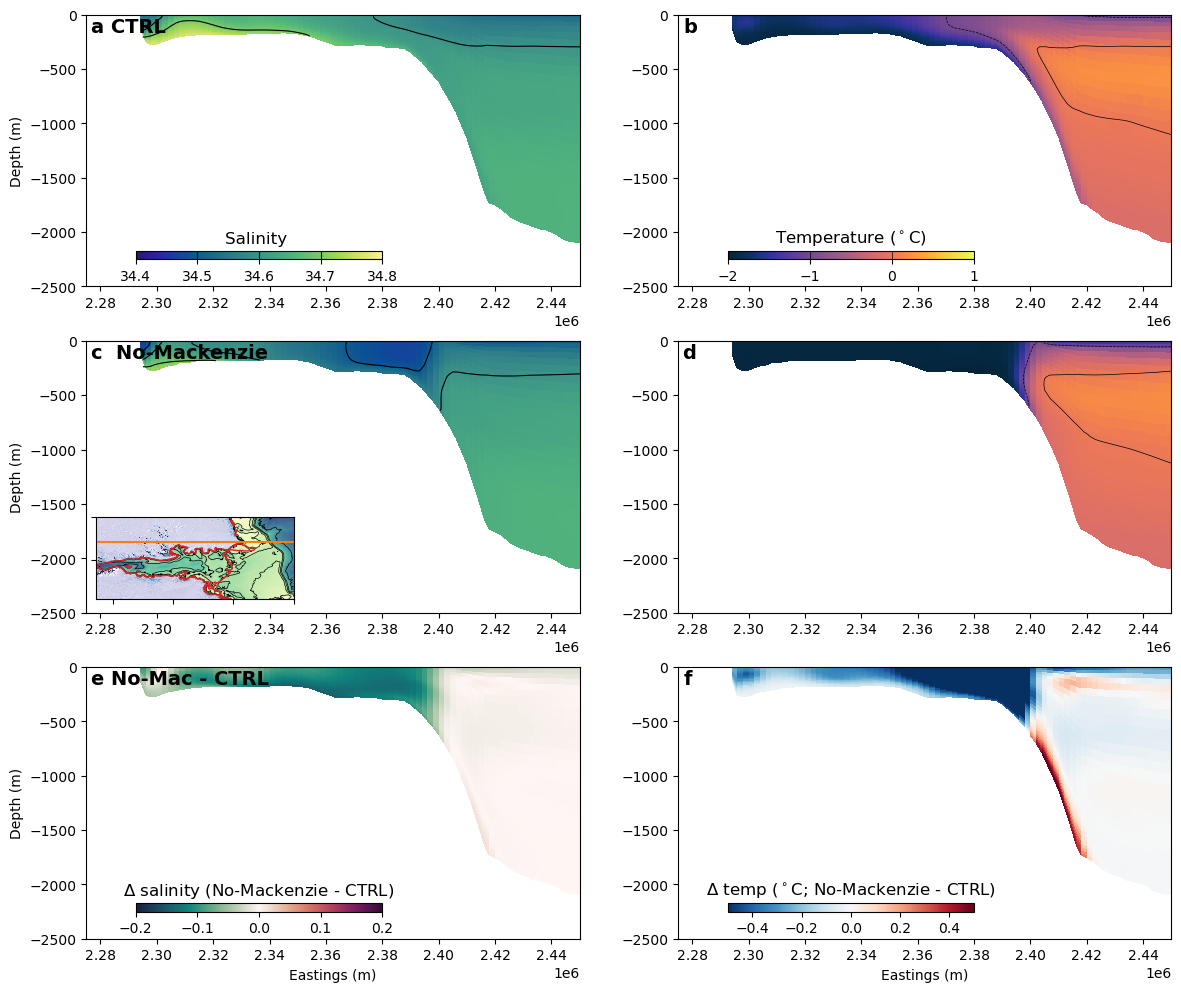

In [96]:
where = 427
xbnds=(2.275e6,2.45e6)
ybnds=(-2500,0)




gs = gridspec.GridSpec(nrows=3,ncols=2,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[14,12])
ax = None

ax=fig.add_subplot(gs[0,0])
co=ds_CTRL.salt_doy.isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot.contour(y='z_rho0',x='x_rho',vmin=34.4,vmax=34.8,colors='k',levels=np.arange(34.4,34.8,.1),linewidths=.8)
im=ds_CTRL.salt_doy.isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot(y='z_rho0',x='x_rho',vmin=34.4,vmax=34.8,cmap='cmo.haline',add_colorbar=False)
ax.set_xlim(xbnds)
ax.set_ylim(ybnds)
ax.text(0.01, 0.99, 'a CTRL', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
# ax.text(0.01, 0.02, ' Salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='bottom')
ax.set_ylabel('Depth (m)')
ax.set_xlabel('')
cax = inset_axes(ax,
                width="50%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.1,.1, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cbar.add_lines(co)
cax.set_title(r'Salinity ',fontsize=12)

ax=fig.add_subplot(gs[1,0])
ds_MKPA.salt_doy.isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot.contour(y='z_rho0',x='x_rho',vmin=34.4,vmax=34.8,colors='k',levels=np.arange(34.4,34.8,.1),linewidths=.8)
ds_MKPA.salt_doy.isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot(y='z_rho0',x='x_rho',vmin=34.4,vmax=34.8,cmap='cmo.haline',add_colorbar=False)
ax.set_xlim(xbnds)
ax.set_ylim(ybnds)
ax.text(0.01, 0.99, 'c  No-Mackenzie', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_ylabel('Depth (m)')
ax.set_xlabel('')


ax=inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="30%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.02,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
(lima.astype('uint8')).plot.imshow()
(ds_CTRL.h*ds_CTRL.mask_rhoNaN).plot(x='x_rho',y='y_rho',cmap='cmo.deep',add_colorbar=False)
(ds_CTRL.h*ds_CTRL.mask_rhoNaN).plot.contour(x='x_rho',y='y_rho',colors='k',levels=[0,250,500,750,1000,2000,3000,4000],add_colorbar=False,linewidths=0.5)
((ds_CTRL.h+ds_CTRL.zice)*ds_CTRL.mask_rho).plot.contour(x='x_rho',y='y_rho',colors='k',levels=[50],add_colorbar=False,linewidths=1)
(ds_CTRL.zice*ds_CTRL.mask_rho).plot.contour(x='x_rho',y='y_rho',colors='C3',levels=(-1,0),add_colorbar=False,linewidths=1,linestyles='-')
ax.axhline(ds_CTRL.y_rho.isel(eta_rho=where).round()[0].values,color='C1')
ax.set_xlabel('')
ax.set_ylabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.52e6,1.0e6))


ax=fig.add_subplot(gs[2,0])
im=(-ds_CTRL.salt_doy+ds_MKPA.salt_doy).isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot(y='z_rho0',x='x_rho',vmin=-.2,vmax=.2,cmap='cmo.curl',add_colorbar=False)
ax.set_xlim(xbnds)
ax.set_ylim(ybnds)
ax.text(0.01, 0.99, 'e No-Mac - CTRL', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlabel('Eastings (m)')
ax.set_ylabel('Depth (m)')
cax = inset_axes(ax,
                width="50%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.1,.1, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'$\Delta$ salinity (No-Mackenzie - CTRL)',fontsize=12)

ax=fig.add_subplot(gs[0,1])
co=ds_CTRL.temp_doy.isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot.contour(y='z_rho0',x='x_rho',vmin=-2,vmax=1,colors='k',levels=np.arange(-2,1),linewidths=.5)
im=ds_CTRL.temp_doy.isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot(y='z_rho0',x='x_rho',vmin=-2,vmax=1,cmap='cmo.thermal',add_colorbar=False)
ax.set_xlim(xbnds)
ax.set_ylim(ybnds)
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
# ax.text(0.01, 0.02, ' Temperature', transform=ax.transAxes,fontsize=14, fontweight='bold', va='bottom')
ax.set_xlabel('')
ax.set_ylabel('')
cax = inset_axes(ax,
                width="50%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.1,.1, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cbar.add_lines(co)
cax.set_title(r'Temperature ($^\circ$C)',fontsize=12)

ax=fig.add_subplot(gs[1,1])
ds_MKPA.temp_doy.isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot(y='z_rho0',x='x_rho',vmin=-2,vmax=1,cmap='cmo.thermal',add_colorbar=False)
ds_MKPA.temp_doy.isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot.contour(y='z_rho0',x='x_rho',vmin=-2,vmax=1,colors='k',levels=np.arange(-2,1),linewidths=.5)
ax.set_xlim(xbnds)
ax.set_ylim(ybnds)
ax.text(0.01, 0.99, 'd ', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlabel('')
ax.set_ylabel('')


ax=fig.add_subplot(gs[2,1])
im=(-ds_CTRL.temp_doy+ds_MKPA.temp_doy).isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot(y='z_rho0',x='x_rho',vmin=-.5,vmax=.5,cmap='RdBu_r',add_colorbar=False)
ax.set_xlim(xbnds)
ax.set_ylim(ybnds)
ax.text(0.01, 0.99, 'f', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlabel('Eastings (m)')
ax.set_ylabel('')
cax = inset_axes(ax,
                width="50%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.1,.1, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'$\Delta$ temp ($^\circ$C; No-Mackenzie - CTRL)',fontsize=12)



Text(0.5, 1.0, '$\\Delta$ temp ($^\\circ$C; No-Mackenzie - CTRL)')

<Figure size 640x480 with 0 Axes>

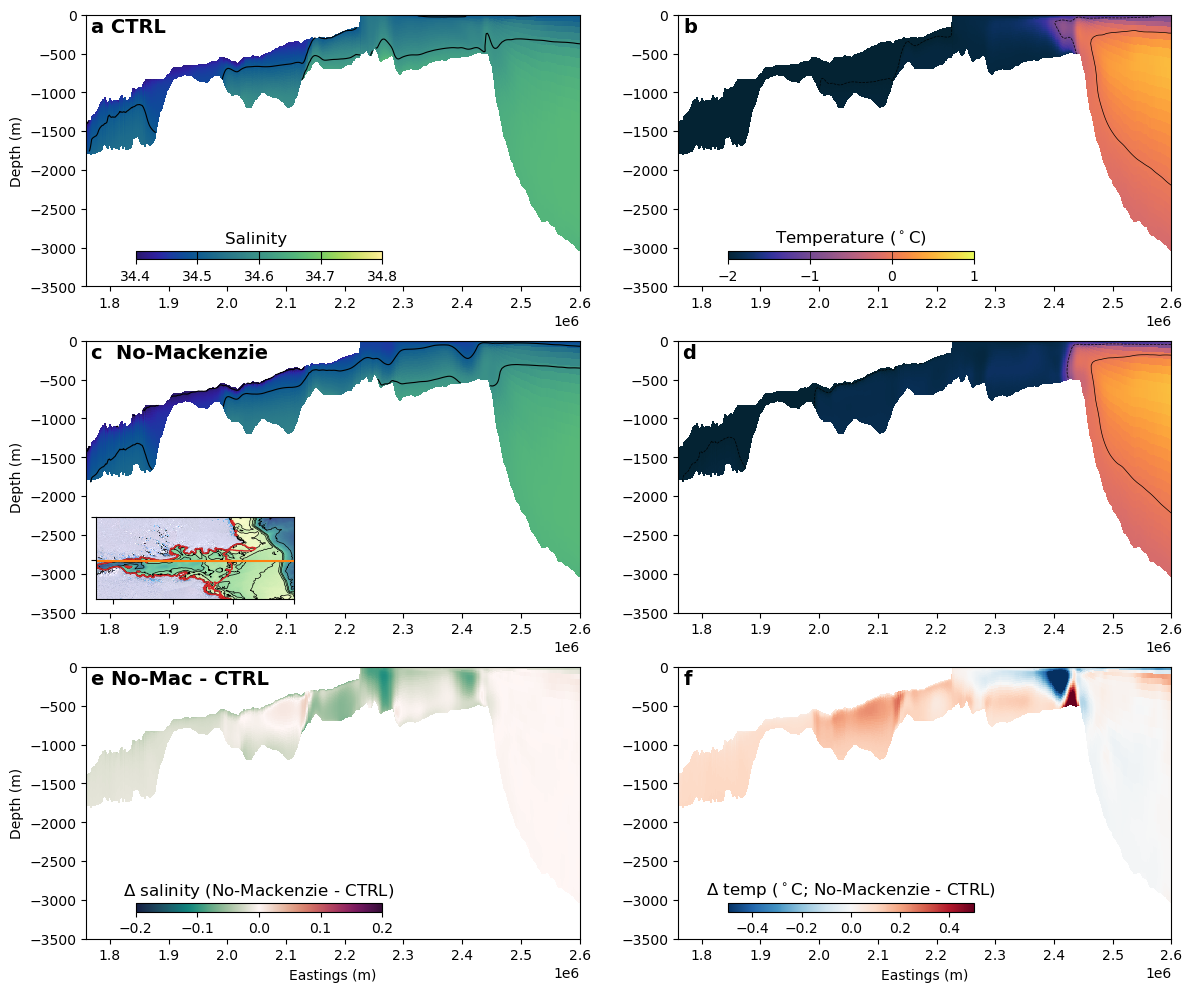

In [103]:
where = 370
xbnds=(1.76e6,2.6e6)
ybnds=(-3500,0)





gs = gridspec.GridSpec(nrows=3,ncols=2,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[14,12])
ax = None

ax=fig.add_subplot(gs[0,0])
co=ds_CTRL.salt_doy.isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot.contour(y='z_rho0',x='x_rho',vmin=34.4,vmax=34.8,colors='k',levels=np.arange(34.4,34.8,.1),linewidths=.8)
im=ds_CTRL.salt_doy.isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot(y='z_rho0',x='x_rho',vmin=34.4,vmax=34.8,cmap='cmo.haline',add_colorbar=False)
ax.set_xlim(xbnds)
ax.set_ylim(ybnds)
ax.text(0.01, 0.99, 'a CTRL', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
# ax.text(0.01, 0.02, ' Salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='bottom')
ax.set_ylabel('Depth (m)')
ax.set_xlabel('')
cax = inset_axes(ax,
                width="50%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.1,.1, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cbar.add_lines(co)
cax.set_title(r'Salinity ',fontsize=12)

ax=fig.add_subplot(gs[1,0])
ds_MKPA.salt_doy.isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot.contour(y='z_rho0',x='x_rho',vmin=34.4,vmax=34.8,colors='k',levels=np.arange(34.4,34.8,.1),linewidths=.8)
ds_MKPA.salt_doy.isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot(y='z_rho0',x='x_rho',vmin=34.4,vmax=34.8,cmap='cmo.haline',add_colorbar=False)
ax.set_xlim(xbnds)
ax.set_ylim(ybnds)
ax.text(0.01, 0.99, 'c  No-Mackenzie', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_ylabel('Depth (m)')
ax.set_xlabel('')


ax=inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="30%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.02,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
(lima.astype('uint8')).plot.imshow()
(ds_CTRL.h*ds_CTRL.mask_rhoNaN).plot(x='x_rho',y='y_rho',cmap='cmo.deep',add_colorbar=False)
(ds_CTRL.h*ds_CTRL.mask_rhoNaN).plot.contour(x='x_rho',y='y_rho',colors='k',levels=[0,250,500,750,1000,2000,3000,4000],add_colorbar=False,linewidths=0.5)
((ds_CTRL.h+ds_CTRL.zice)*ds_CTRL.mask_rho).plot.contour(x='x_rho',y='y_rho',colors='k',levels=[50],add_colorbar=False,linewidths=1)
(ds_CTRL.zice*ds_CTRL.mask_rho).plot.contour(x='x_rho',y='y_rho',colors='C3',levels=(-1,0),add_colorbar=False,linewidths=1,linestyles='-')
ax.axhline(ds_CTRL.y_rho.isel(eta_rho=where).round()[0].values,color='C1')
ax.set_xlabel('')
ax.set_ylabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.52e6,1.0e6))


ax=fig.add_subplot(gs[2,0])
im=(-ds_CTRL.salt_doy+ds_MKPA.salt_doy).isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot(y='z_rho0',x='x_rho',vmin=-.2,vmax=.2,cmap='cmo.curl',add_colorbar=False)
ax.set_xlim(xbnds)
ax.set_ylim(ybnds)
ax.text(0.01, 0.99, 'e No-Mac - CTRL', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlabel('Eastings (m)')
ax.set_ylabel('Depth (m)')
cax = inset_axes(ax,
                width="50%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.1,.1, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'$\Delta$ salinity (No-Mackenzie - CTRL)',fontsize=12)

ax=fig.add_subplot(gs[0,1])
co=ds_CTRL.temp_doy.isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot.contour(y='z_rho0',x='x_rho',vmin=-2,vmax=1,colors='k',levels=np.arange(-2,1),linewidths=.5)
im=ds_CTRL.temp_doy.isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot(y='z_rho0',x='x_rho',vmin=-2,vmax=1,cmap='cmo.thermal',add_colorbar=False)
ax.set_xlim(xbnds)
ax.set_ylim(ybnds)
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
# ax.text(0.01, 0.02, ' Temperature', transform=ax.transAxes,fontsize=14, fontweight='bold', va='bottom')
ax.set_xlabel('')
ax.set_ylabel('')
cax = inset_axes(ax,
                width="50%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.1,.1, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cbar.add_lines(co)
cax.set_title(r'Temperature ($^\circ$C)',fontsize=12)

ax=fig.add_subplot(gs[1,1])
ds_MKPA.temp_doy.isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot(y='z_rho0',x='x_rho',vmin=-2,vmax=1,cmap='cmo.thermal',add_colorbar=False)
ds_MKPA.temp_doy.isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot.contour(y='z_rho0',x='x_rho',vmin=-2,vmax=1,colors='k',levels=np.arange(-2,1),linewidths=.5)
ax.set_xlim(xbnds)
ax.set_ylim(ybnds)
ax.text(0.01, 0.99, 'd ', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlabel('')
ax.set_ylabel('')


ax=fig.add_subplot(gs[2,1])
im=(-ds_CTRL.temp_doy+ds_MKPA.temp_doy).isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot(y='z_rho0',x='x_rho',vmin=-.5,vmax=.5,cmap='RdBu_r',add_colorbar=False)
ax.set_xlim(xbnds)
ax.set_ylim(ybnds)
ax.text(0.01, 0.99, 'f', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlabel('Eastings (m)')
ax.set_ylabel('')
cax = inset_axes(ax,
                width="50%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.1,.1, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'$\Delta$ temp ($^\circ$C; No-Mackenzie - CTRL)',fontsize=12)


(520000.0, 1000000.0)

<Figure size 640x480 with 0 Axes>

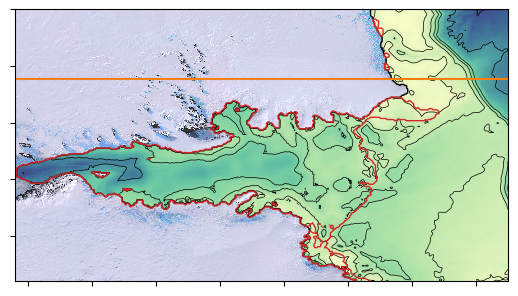

In [87]:


gs = gridspec.GridSpec(nrows=3,ncols=2,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[14,12])
ax = None

ax=fig.add_subplot(gs[0,0])
# ds_CTRL.salt_doy.isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot()
# plt.axhline(348)
# plt.axhline(427)
# plt.axhline(490)


ax=inset_axes(ax,
                width="45%",  # width = 10% of parent_bbox width
                height="26%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.02,.67, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
(lima.astype('uint8')).plot.imshow()
(ds_CTRL.h*ds_CTRL.mask_rhoNaN).plot(x='x_rho',y='y_rho',cmap='cmo.deep',add_colorbar=False)
(ds_CTRL.h*ds_CTRL.mask_rhoNaN).plot.contour(x='x_rho',y='y_rho',colors='k',levels=[0,250,500,750,1000,2000,3000,4000],add_colorbar=False,linewidths=0.5)
((ds_CTRL.h+ds_CTRL.zice)*ds_CTRL.mask_rho).plot.contour(x='x_rho',y='y_rho',colors='k',levels=[50],add_colorbar=False,linewidths=1)
(ds_CTRL.zice*ds_CTRL.mask_rho).plot.contour(x='x_rho',y='y_rho',colors='C3',levels=(-1,0),add_colorbar=False,linewidths=1,linestyles='-')
ax.axhline(ds_CTRL.y_rho.isel(eta_rho=438).round()[0].values,color='C1')
ax.set_xlabel('')
ax.set_ylabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('')
ax.set_xlim((1.68e6,2.45e6))
ax.set_ylim((.52e6,1.0e6))

Text(0.5, 1.0, '$\\Delta$ temp ($^\\circ$C; No-Mackenzie - CTRL)')

<Figure size 640x480 with 0 Axes>

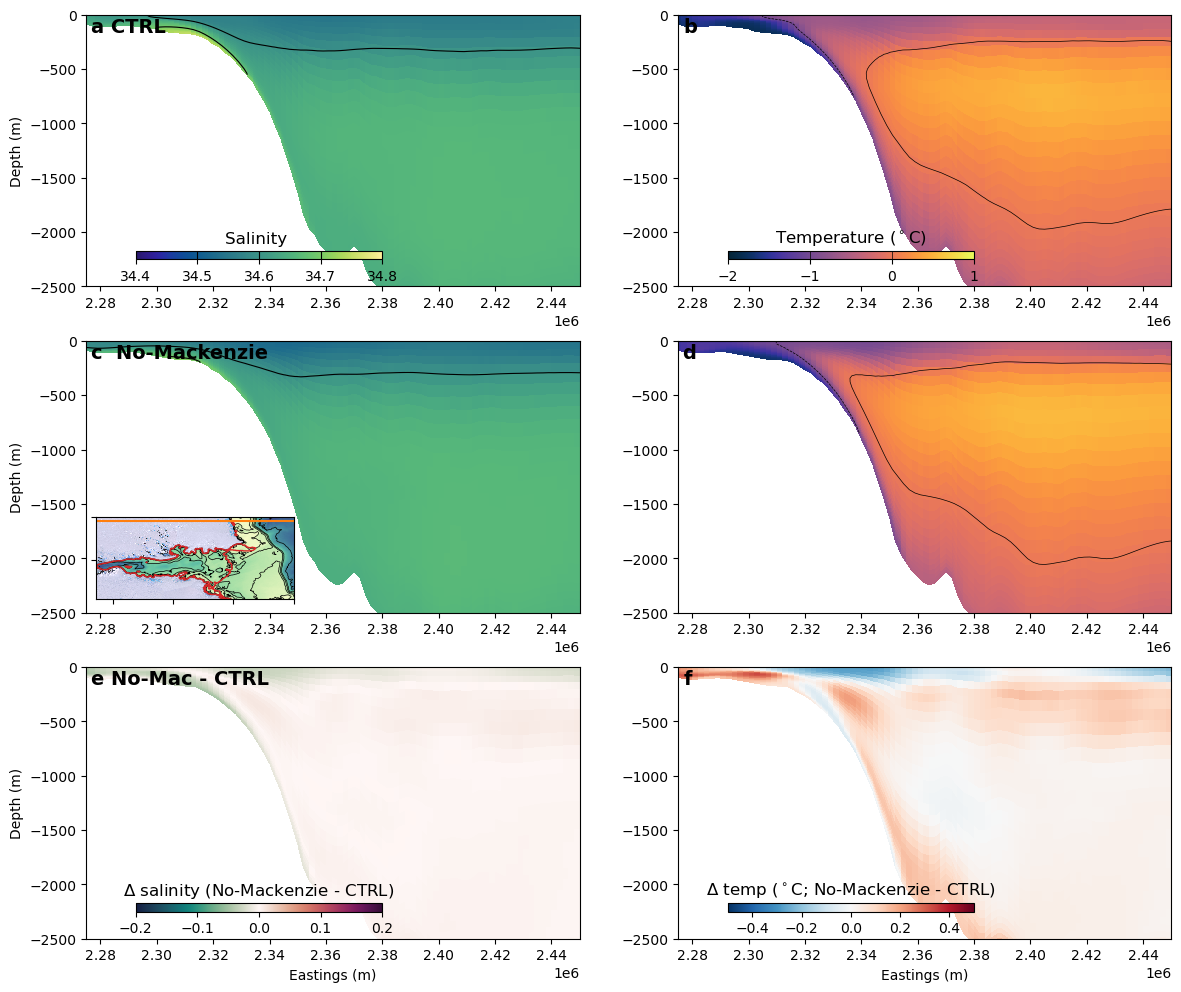

In [95]:
where = 490
xbnds=(2.275e6,2.45e6)
ybnds=(-2500,0)




gs = gridspec.GridSpec(nrows=3,ncols=2,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[14,12])
ax = None

ax=fig.add_subplot(gs[0,0])
co=ds_CTRL.salt_doy.isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot.contour(y='z_rho0',x='x_rho',vmin=34.4,vmax=34.8,colors='k',levels=np.arange(34.4,34.8,.1),linewidths=.8)
im=ds_CTRL.salt_doy.isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot(y='z_rho0',x='x_rho',vmin=34.4,vmax=34.8,cmap='cmo.haline',add_colorbar=False)
ax.set_xlim(xbnds)
ax.set_ylim(ybnds)
ax.text(0.01, 0.99, 'a CTRL', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
# ax.text(0.01, 0.02, ' Salinity', transform=ax.transAxes,fontsize=14, fontweight='bold', va='bottom')
ax.set_ylabel('Depth (m)')
ax.set_xlabel('')
cax = inset_axes(ax,
                width="50%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.1,.1, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cbar.add_lines(co)
cax.set_title(r'Salinity ',fontsize=12)

ax=fig.add_subplot(gs[1,0])
ds_MKPA.salt_doy.isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot.contour(y='z_rho0',x='x_rho',vmin=34.4,vmax=34.8,colors='k',levels=np.arange(34.4,34.8,.1),linewidths=.8)
ds_MKPA.salt_doy.isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot(y='z_rho0',x='x_rho',vmin=34.4,vmax=34.8,cmap='cmo.haline',add_colorbar=False)
ax.set_xlim(xbnds)
ax.set_ylim(ybnds)
ax.text(0.01, 0.99, 'c  No-Mackenzie', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_ylabel('Depth (m)')
ax.set_xlabel('')


ax=inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="30%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.02,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
(lima.astype('uint8')).plot.imshow()
(ds_CTRL.h*ds_CTRL.mask_rhoNaN).plot(x='x_rho',y='y_rho',cmap='cmo.deep',add_colorbar=False)
(ds_CTRL.h*ds_CTRL.mask_rhoNaN).plot.contour(x='x_rho',y='y_rho',colors='k',levels=[0,250,500,750,1000,2000,3000,4000],add_colorbar=False,linewidths=0.5)
((ds_CTRL.h+ds_CTRL.zice)*ds_CTRL.mask_rho).plot.contour(x='x_rho',y='y_rho',colors='k',levels=[50],add_colorbar=False,linewidths=1)
(ds_CTRL.zice*ds_CTRL.mask_rho).plot.contour(x='x_rho',y='y_rho',colors='C3',levels=(-1,0),add_colorbar=False,linewidths=1,linestyles='-')
ax.axhline(ds_CTRL.y_rho.isel(eta_rho=where).round()[0].values,color='C1')
ax.set_xlabel('')
ax.set_ylabel('')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.52e6,1.0e6))


ax=fig.add_subplot(gs[2,0])
im=(-ds_CTRL.salt_doy+ds_MKPA.salt_doy).isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot(y='z_rho0',x='x_rho',vmin=-.2,vmax=.2,cmap='cmo.curl',add_colorbar=False)
ax.set_xlim(xbnds)
ax.set_ylim(ybnds)
ax.text(0.01, 0.99, 'e No-Mac - CTRL', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlabel('Eastings (m)')
ax.set_ylabel('Depth (m)')
cax = inset_axes(ax,
                width="50%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.1,.1, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'$\Delta$ salinity (No-Mackenzie - CTRL)',fontsize=12)

ax=fig.add_subplot(gs[0,1])
co=ds_CTRL.temp_doy.isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot.contour(y='z_rho0',x='x_rho',vmin=-2,vmax=1,colors='k',levels=np.arange(-2,1),linewidths=.5)
im=ds_CTRL.temp_doy.isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot(y='z_rho0',x='x_rho',vmin=-2,vmax=1,cmap='cmo.thermal',add_colorbar=False)
ax.set_xlim(xbnds)
ax.set_ylim(ybnds)
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
# ax.text(0.01, 0.02, ' Temperature', transform=ax.transAxes,fontsize=14, fontweight='bold', va='bottom')
ax.set_xlabel('')
ax.set_ylabel('')
cax = inset_axes(ax,
                width="50%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.1,.1, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cbar.add_lines(co)
cax.set_title(r'Temperature ($^\circ$C)',fontsize=12)

ax=fig.add_subplot(gs[1,1])
ds_MKPA.temp_doy.isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot(y='z_rho0',x='x_rho',vmin=-2,vmax=1,cmap='cmo.thermal',add_colorbar=False)
ds_MKPA.temp_doy.isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot.contour(y='z_rho0',x='x_rho',vmin=-2,vmax=1,colors='k',levels=np.arange(-2,1),linewidths=.5)
ax.set_xlim(xbnds)
ax.set_ylim(ybnds)
ax.text(0.01, 0.99, 'd ', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlabel('')
ax.set_ylabel('')


ax=fig.add_subplot(gs[2,1])
im=(-ds_CTRL.temp_doy+ds_MKPA.temp_doy).isel(eta_rho=where).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').plot(y='z_rho0',x='x_rho',vmin=-.5,vmax=.5,cmap='RdBu_r',add_colorbar=False)
ax.set_xlim(xbnds)
ax.set_ylim(ybnds)
ax.text(0.01, 0.99, 'f', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlabel('Eastings (m)')
ax.set_ylabel('')
cax = inset_axes(ax,
                width="50%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.1,.1, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax, orientation='horizontal') 
cax.set_title(r'$\Delta$ temp ($^\circ$C; No-Mackenzie - CTRL)',fontsize=12)


In [20]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
(ds_CTRL.salt_doy.isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho'))).values / \
(ds_MKPA.salt_doy.isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho'))).values

In [ ]:
# calculate mean of annual salt variation.
salt_mn = (ds_CTRL.salt_doy.isel(s_rho=0).mean(dim='dayofyear').where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho'))).values 
print(salt_mn)
salt_std = (ds_CTRL.salt_doy.isel(s_rho=0).std(dim='dayofyear').where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho'))).values 
print(salt_std)

salt_mn_mkpa = (ds_MKPA.salt_doy.isel(s_rho=0).mean(dim='dayofyear').where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho'))).values 
print(salt_mn_mkpa)
salt_std_mkpa = (ds_MKPA.salt_doy.isel(s_rho=0).std(dim='dayofyear').where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho'))).values 
print(salt_std_mkpa)

(ds_MKPA.salt_doy.isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho'))).values

In [ ]:
(ds_CTRL.salt_doy.isel(s_rho=0).mean(dim='dayofyear').where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho'))).values 

In [ ]:
(ds_MKPA.salt_doy.isel(s_rho=0).mean(dim='dayofyear').where(mask_capedarnley==1).weighted(weights).mean(('xi_rho','eta_rho'))).values 

In [ ]:
(salt_mn_mkpa-salt_mn)/salt_std

In [ ]:
salt_std

In [ ]:
(salt_mn-salt_mn_mkpa)/salt_std_mkpa

In [ ]:
salt_std_mkpa

In [ ]:
image_save_dpi = 1250
image_web_dpi = plt.rcParams['figure.dpi']
plt.rcParams['figure.dpi'] = image_save_dpi
plt.rcParams.update({'font.size': 16})
plt.rcParams['xtick.labelsize']=16



ub_rho_ctrl   = ds_CTRL.u_rho_doy.isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').values   
vb_rho_ctrl   = ds_CTRL.v_rho_doy.isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').values   
ub_rho_mkpa   = ds_MKPA.u_rho_doy.isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').values   
vb_rho_mkpa   = ds_MKPA.v_rho_doy.isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear').values   

uvel1=ub_rho_ctrl
vvel1=vb_rho_ctrl
uvel2=ub_rho_mkpa
vvel2=vb_rho_mkpa

# No_Mack - CTRL => +ve means increased salinity, -ve means reduction in salinity
# or CTRL - No_Mack => +ve means CTRL>No_Mack, so +ve means that No_Mack reduces salinity in this area => +ve means Mac increases salinity here.
diff_plot = (ds_MKPA.mask_rho*(ds_MKPA.mask_rhoNaN)*ds_MKPA.salt_doy.isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear')) - (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.salt_doy.isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear'))
# diff_plot_t = -(ds_MKPA.mask_rho*(ds_MKPA.mask_rhoNaN)*ds_MKPA.temp_doy.isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear')) + \
# (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.temp_doy.isel(s_rho=0).isel(dayofyear=winter_period_doy).mean(dim='dayofyear'))

# diff_plot2 = -(ds_MKPA.mask_rho*(ds_MKPA.mask_rhoNaN)*ds_MKPA.my_doy.isel(dayofyear=winter_period_doy).mean(dim='dayofyear')) + (ds_CTRL.mask_rho*(ds_CTRL.mask_rhoNaN)*ds_CTRL.my_doy.isel(dayofyear=winter_period_doy).mean(dim='dayofyear'))



gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.2, hspace=0.2)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[23*.5,14*.5])
ax = None

#####################################

ax=fig.add_subplot(gs[0,0])
(lima.astype('uint8')).plot.imshow()

# im1 = (ds_dailyclima.my_doy*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.balance',vmin=-10,vmax=10,add_colorbar=False)
im2 = diff_plot.plot(ax=ax,x='x_rho',y='y_rho',cmap='cmo.curl',vmin=-.25,vmax=.25,add_colorbar=False)

# co1 = (ds_dailyclima.my_doy*ds.mask_zice.where(ds.mask_zice,np.NaN)).mean(dim='dayofyear').plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(np.arange(-10,10,5)),colors='k',linewidths=1)
co2 = (ds_CTRL.h*ds_CTRL.mask_rho*(ds_CTRL.mask_zice==0)).plot.contour(ax=ax,x='x_rho',y='y_rho',levels=(0,250,500,750,1000,2000,3000),colors='k',linestyles='-',linewidths=1)
co3 = ax.contour(ds_CTRL.x_rho,ds_CTRL.y_rho,ds_CTRL.zice*ds_CTRL.mask_rho,levels=(-1,0),colors='C3',linestyles='-',linewidths=1)

ax.quiver(grd.x_rho.values[0::5,0::5], grd.y_rho.values[0::5,0::5], uvel1[0::5,0::5], vvel1[0::5,0::5],scale=4,minshaft = 1, minlength=0)

# ax.text(0.01, 0.99, 'a  mean melt', transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.set_xlim((1.68e6,2.5e6))
ax.set_ylim((.4e6,1.0e6))
ax.set_ylabel('Northings (km)')
ax.set_xlabel('Eastings (km)')
# ax.grid()
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax.yaxis.set_major_formatter(ticks_y)
# ax.set_xticklabels([])
ax.set_title('')

# ax.text(0.01, 0.99, """ Salinity impact
#    of Mackenzie polynya""", transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')
ax.text(0.01, 0.99, """ Impact on salinity
   of removing Mackenzie polynya""", transform=ax.transAxes,fontsize=20, fontweight='bold', va='top')

cax = inset_axes(ax,
                width="40%",  # width = 10% of parent_bbox width
                height="3%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.15,.1, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im2, cax=cax, orientation='horizontal') 
cax.set_title(r'$\Delta$ salinity (No-Mackenzie - CTRL)',fontsize=18)
